# 1. Importing The Modules

In [1]:
import numpy as np   # Algebra 
import pandas as pd  # Handle tabular data and more
import matplotlib.pyplot as plt # To visualize photos of the fishes.
import seaborn as sns # Extends matplotlib's abilities
import os            # Being able to Operating System and get files from directory
import cv2

from concurrent.futures import ThreadPoolExecutor # Parallel computing while convering images to matrices

from pathlib import Path # Makes better working with paths
from sklearn.model_selection import train_test_split # For holdout, CV and other kinds of data splitting methods
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping # Early stopping fitting to avoid extra epochs
from tensorflow import keras # This and later imports are for avoiding unnecessary codes like reaching Dense layer from TensorFlow's itself. So, clean code principle is welcomed. 
from tensorflow.keras.utils import to_categorical # Apply One Hot Encoding to labels. 
from sklearn.preprocessing import OneHotEncoder # Apply One Hot Encoder to labels which are nominal categoric variables
from tensorflow.keras.models import Sequential # The image going to be converted to 1D array & each element of array(pixels) are meaningful with rest. So Sequential model has been choosen.
from tensorflow.keras.layers import Dense, Dropout, Flatten # These are layers which going to be used in ANN. Long explanation of reasons beyond choosing them going to be highlighted later.
from tensorflow.keras.optimizers import Adam # Adaptive Moment Estimation
# For evaluating model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf


# 2.Fish Dataset Processing

## Part A
Define filepath as a Path object.

## Part B
Since all photos are in .png format, build a list which contains filepaths of all .png files. 

- `len(filepaths)` is equal to the photograph count.
- `.glob` is similar to the "LIKE" command in SQL.
- Example:
'''
[ '../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/SpeciesA/image1.png'


'''

## Part C
Extract labels from each filepath.

- **`map`**: Applies a function (in this case, a lambda function) to each element in `filepaths`.

- **`lambda x`**: Represents each path in `filepaths`. 
- Example: 
  ```
  x = "../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/SpeciesA/image1.png"
  ```

- **`os.path.split(x)`**: Splits the file path into two parts: the directory and the file name.
- Example: 
  - Directory: `"../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/SpeciesA/"`
  - Filename: `image1.png`

- **`os.path.split(x)[0]`**: Extracts the directory part of the file path.
- Example: 
  - Directory: `"../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/SpeciesA/"`

- **`os.path.split(os.path.split(x)[0])[1]`**: Splits the directory path again to get the name of the directory (i.e., the label).
- Example: 
  - Filename: `SpeciesA`

- **`labels`**: Contains a list of these directory names, effectively representing the labels for each image file.
- Example: 
  ```
  [SpeciesA, SpeciesA, SpeciesA, SpeciesA, SpeciesB, SpeciesC, SpeciesB, ...]
  ```

## Part D
Merge filepaths and labels.

- **Q**: How to store them together?  
- **A**: Build a DataFrame for each list, then merge them!

- Keep in mind to set the type of labels as String. Even if it is already String, guarantee it.

As can be observed, the dataset contains some folders that have "GT" tag at the last 2 chars of the directory. They are not desired in either training or validation set since "GT" means "Ground Truth." The GT set is going to be used to evaluate the model. So, get rid of them.

- **Q**: How?  
- **A**: Apply a lambda function that returns True/False based on whether the last 2 chars of the label are "GT" or not. 

## Part E
Resampling, a.k.a. Shuffling data.

- **`sample()`**: This method is used to randomly sample rows from the DataFrame.
- **`frac=1`**: This argument specifies the fraction of the DataFrame to return. Here, `frac=1` means that we want to sample 100% of the rows in `img_df`, effectively returning a shuffled version of the entire DataFrame.

### Purpose
This is a common technique to shuffle the data, ensuring that the order of samples does not introduce any bias. For example, if the data were sorted in a particular way (like all images of one species appearing together), shuffling helps mix them up. 

- Example: Examine the Iris dataset; there are 3 labels, and they are in order. We don’t know or we don’t want to waste energy checking it; we are just shuffling. It will be resampled when constructing validation and training sets.

## Part F
REAPING THE REWARDS, actually just visualizing first 5 row of df_img we just created.

In [2]:
# Part A
directory = Path("../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset")

# Part B
filepaths = list(directory.glob(r"**/*.png"))

# Part C
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# Part D
df_filepath = pd.Series(filepaths, name="filepaths").astype(str)
df_labels = pd.Series(labels, name="labels").astype(str)

df_img = pd.DataFrame(columns=['path','labels'])
df_img["path"] = df_filepath
df_img["labels"] = df_labels

df_img = df_img[df_img['labels'].apply(lambda x: x[-2:]!='GT') ]

# Part E
df_img = df_img.sample(frac=1).reset_index(drop = True)

In [3]:
# Part F
df_img.head(5)

,path,labels
0,../input/a-large-scale-fish-dataset/Fish_Datas...,Sea Bass
1,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream
2,../input/a-large-scale-fish-dataset/Fish_Datas...,Trout
3,../input/a-large-scale-fish-dataset/Fish_Datas...,Shrimp
4,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Mullet


# 3.EDA (Exploratory Data Analysis)

## Part A
**How many fish are in my net (I mean dataset :D)?**

## Part B
**How many fish types are in the dataset?**

## Part C
**How many unique labels does the dataset have?**

## Part D
Get insight into how the fish were photographed.

- Since there are 9 unique fish types, let's visualize one fish for each type.
- `df_img["labels"].unique()` returns the array of the column names.
- Using `enumerate()`, the index is also tracked while iterating.


In [4]:
# Part A
df_img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   labels  9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


How many fish types in dataset: labels
Sea Bass              1000
Red Sea Bream         1000
Trout                 1000
Shrimp                1000
Red Mullet            1000
Gilt-Head Bream       1000
Black Sea Sprat       1000
Hourse Mackerel       1000
Striped Red Mullet    1000
Name: count, dtype: int64



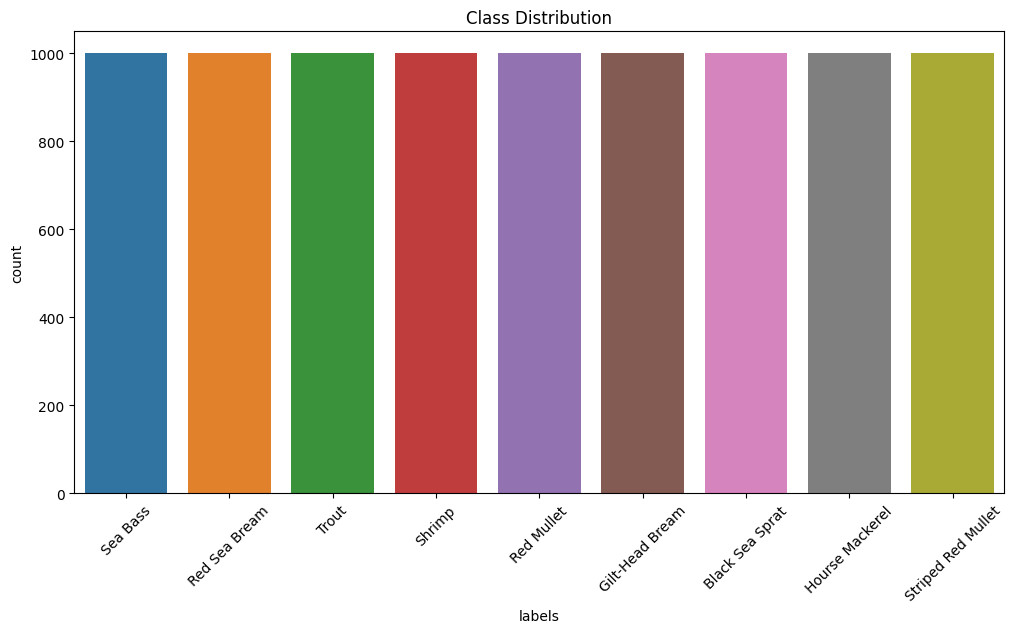

How many unique labels does the dataset have: 9


In [5]:
# Part B
print(f"How many fish types in dataset: {df_img['labels'].value_counts()}\n")

# Also, let's visualize it by:
plt.figure(figsize=(12,6))
sns.countplot(x='labels', data=df_img) # x: Classes
plt.xticks(rotation=45)
plt.title('Class Distribution')
plt.show()

# Part C
print(f"How many unique labels does the dataset have: {df_img['labels'].nunique()}")


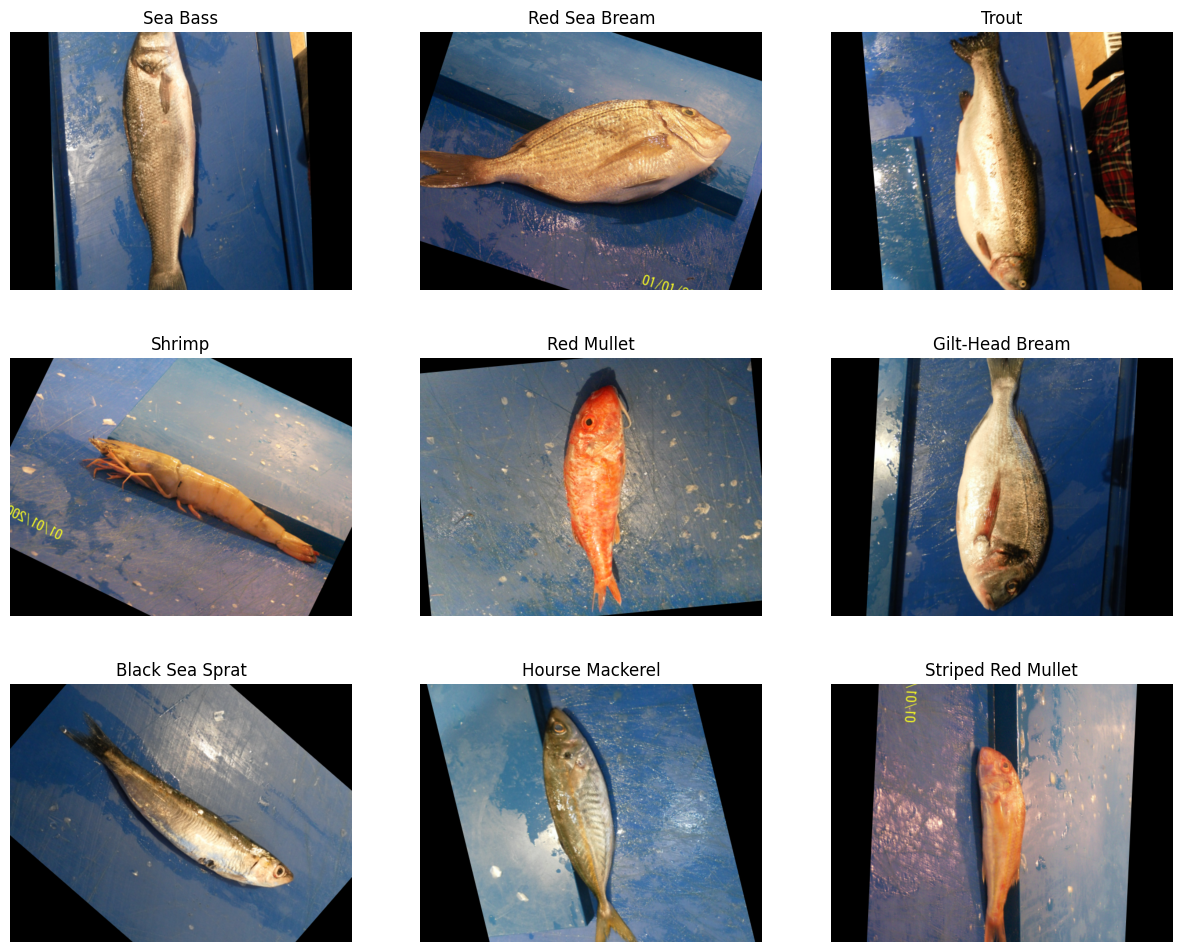

In [6]:
# Part D
plt.figure(figsize=(15, 12))
for idx, label in enumerate(df_img['labels'].unique()):
    plt.subplot(3, 3, idx + 1)
    # plt.imread(first photograph's filepath of that label (.iloc[0,0]))
    plt.imshow(plt.imread(df_img[df_img['labels'] == label].iloc[0, 0]))
    plt.title(label)
    plt.axis('off')
plt.show()

# 4. Upload Images to Array

In [7]:
# Method loads only 1 image with Resizing and Normalizing
def load_single_image(path, new_size):
    img_array = cv2.imread(path)  # Görüntüyü okuma
    img_array = cv2.resize(img_array, new_size)  # Görüntüyü yeniden boyutlandırma
    img_array = img_array / 255.0  # Normalizasyon
    return img_array

# With using load_single_image, extracts images from their path.
# While doing this, uses parallel computing to increase efficency
def load_images(filepaths, batch_size=32, new_size=(224,224)):
    num_images = len(filepaths)
    # Set image size after reshaping
    image_shape = (*new_size, 3)  # (height, width, channels)
    # Allocate memory for converted images with empty numpy array.
    images = np.empty((num_images, *image_shape), dtype=np.float32)  

    with ThreadPoolExecutor() as executor:
        for i in range(0, num_images, batch_size):
            batch_paths = filepaths[i:i + batch_size]
            batch_images = list(executor.map(lambda path: load_single_image(path, new_size), batch_paths))  # Parallel yükleme
            
            # Append image arrays inside empty array previously initalized
            images[i:i + len(batch_images)] = batch_images
    #Return converted image's array
    return images  

# X contains numpy array of converted images for each path column in df_img
X = load_images(df_img['path'], batch_size=32, new_size=(224,224))

# y contains numpy array version of labels column of df_img DataFrame
y = df_img['labels'].values

In [8]:
# What is the meaning of X.shape is (9000, 445, 590, 3):

# 9000: Count of photos
# 445: Pixel count for width
# 590: Pixel count for height
# 3: Since photos are colored, there are 3 layers called Red Green Blue (RGB)
X.shape


(9000, 224, 224, 3)

In [9]:
# Examine each pixel's value range. Checking is normalization applied or not.
def check_pixel_value_range(images):
    # Piksel değer aralığını kontrol et
    min_value = np.min(images)
    max_value = np.max(images)
    return min_value, max_value

# Piksel değer aralığını kontrol edin
min_value, max_value = check_pixel_value_range(X)
print(f'Min Value: {min_value}, Max Value: {max_value}')



Min Value: 0.0, Max Value: 1.0


In [10]:
# Now, split 9k data to  Train(80%) Validation(10%) Test(10%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [11]:
print(f"Train set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Train set shape: {y_train.shape}")
print(f"Validation set shape: {y_val.shape}")
print(f"Test set shape: {y_test.shape}")

Train set shape: (7200, 224, 224, 3)
Validation set shape: (900, 224, 224, 3)
Test set shape: (900, 224, 224, 3)
Train set shape: (7200,)
Validation set shape: (900,)
Test set shape: (900,)


In [12]:
# Augment Images to avoid overfitting.
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)
datagen.fit(X_train)

In [13]:
# We augmentad image count however, image count of X_train not increased. Reason beyond is, created images are not appended to X_train, they going to be fitted while model is training.
print(f"Train set shape: {X_train.shape}")

Train set shape: (7200, 224, 224, 3)


In [14]:
# Observe labels are still in string format 
# Since resampling is applied, y_test[i] gives different result for each refreshing
y_test[5]

'Red Mullet'

## Apply One Hot Encoding for labels 
- Why?
- If a British understands in English, Deep Learning understands well in numeric representations of strings. So we are representing labels as zeros and ones

In [15]:
encoder = OneHotEncoder(sparse_output=False)
y_train = encoder.fit_transform(y_train.reshape(-1, 1))
y_val = encoder.transform(y_val.reshape(-1, 1))
y_test = encoder.transform(y_test.reshape(-1, 1))

# 5.Modeling
## Hyperparameter Optimization
- During the model training phase, I experimented with various hyperparameter optimization techniques to reduce fluctuations in the training graphs. This included adjusting dropout rates, applying regularization, and adding or removing layers while modifying the number of neurons. I will keep visualizations of these experiments in my repository. Ultimately, the most accurate model was achieved using these parameters.

- Data has just preprocessed, let's fit it into a model

In [16]:

# Initialize a sequential model
model = Sequential([
    # Input layer: Flattening the image input, previously, 2 dimension and 3 channel were existing, after all of them combined as 1 dimension for same reason of One Hot Encoding
    
    Flatten(input_shape=(224, 224, 3)),
    
    # Hidden layer 1: Fully connected layer with 512 neurons and ReLU activation
    Dense(512, activation='relu'),
    
    # Hidden layer 2: Fully connected layer with 256 neurons and ReLU activation
    Dense(256, activation='relu'),

    # Hidden layer 3: Fully connected layer with 128 neurons and ReLU activation
    Dense(128, activation='relu'),

    # Hidden layer 4: Fully connected layer with 64 neurons and ReLU activation
    Dense(64, activation='relu'),
     # Dropout to reduce overfitting
    Dropout(0.15),
    
    # Output layer: Final layer with 9 neurons (for 9 classes) and softmax activation
    Dense(9, activation="softmax")
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [18]:
# Early stopping'i dışarıda tanımla
early_stopping = EarlyStopping(
    monitor='val_loss',   # İzlenecek değer
    patience=10,           # Sabırlı kalınacak epoch sayısı
    restore_best_weights=True  # En iyi ağırlıkları geri yükle

)

In [19]:
# Train Model
results = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100


I0000 00:00:1729797790.109912      79 service.cc:145] XLA service 0x7916780053f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729797790.109995      79 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729797790.110004      79 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  7/225 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.1199 - loss: 3.0028

I0000 00:00:1729797793.602740      79 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.2385 - loss: 2.2733 - val_accuracy: 0.4867 - val_loss: 1.5106
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.4883 - loss: 1.4505 - val_accuracy: 0.6678 - val_loss: 0.9885
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6119 - loss: 1.0946 - val_accuracy: 0.7044 - val_loss: 0.8382
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6602 - loss: 0.9815 - val_accuracy: 0.7900 - val_loss: 0.6149
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.7613 - loss: 0.6970 - val_accuracy: 0.8022 - val_loss: 0.6039
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7877 - loss: 0.6203 - val_accuracy: 0.8400 - val_loss: 0.5248
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8173 - loss: 0.5222 - val_accuracy: 0.8556 - val_loss: 0.3899
Epoch 8/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8562 - loss: 0.4308 - val_accurac

In [20]:
title = "Results of 225*225 Pictures with / YES augmentation / 4 hidden layer(512,256,128,64) / No regularization /  4th hidden layer dropout(0.15) / YES EarlyStopping"

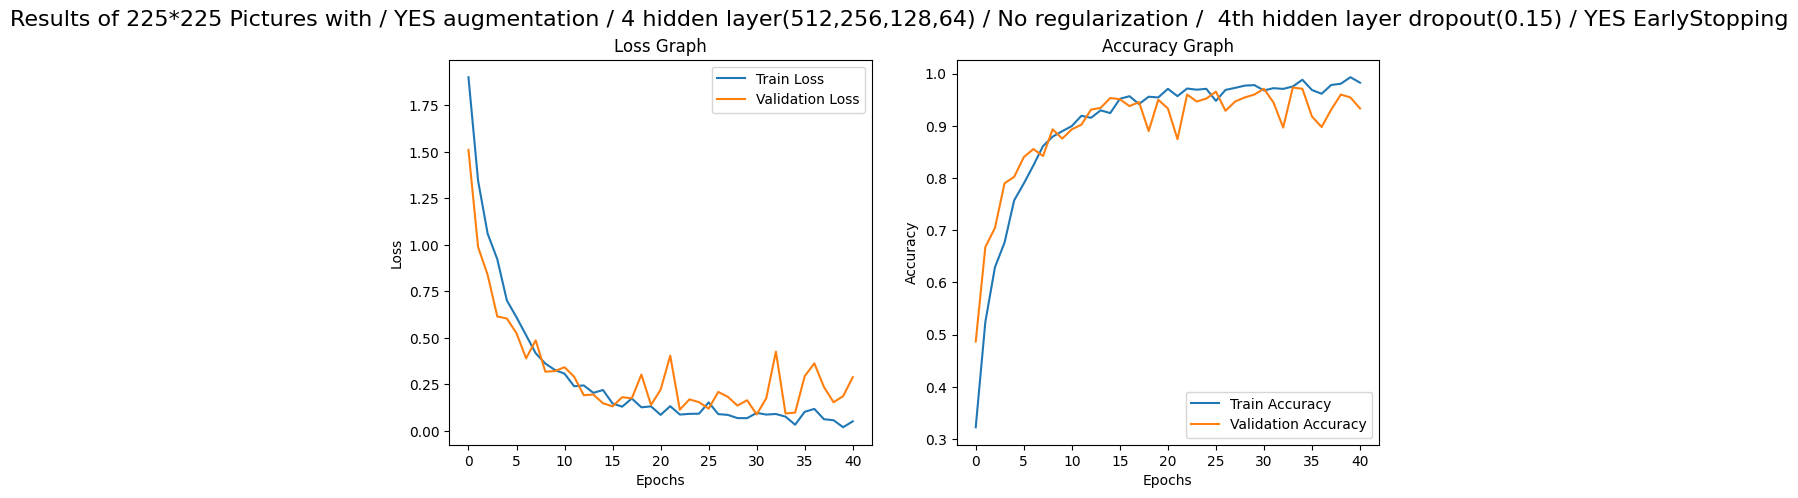

In [21]:
plt.figure(figsize=(12, 5))
plt.suptitle(title, fontsize=16)
# Graph of Loss
plt.subplot(1,2,1)
plt.plot(results.history["loss"], label= "Train Loss")
plt.plot(results.history["val_loss"], label = "Validation Loss")
plt.title("Loss Graph")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()


# Graph of Accuracy
plt.subplot(1,2,2)
plt.plot(results.history["accuracy"], label = "Train Accuracy")
plt.plot(results.history["val_accuracy"], label = "Validation Accuracy")
plt.title("Accuracy Graph")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# 6.Model Evaluating

In [22]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

29/29 - 0s - 11ms/step - accuracy: 0.9744 - loss: 0.0817
Test accuracy: 0.9744444489479065


In [23]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


              precision    recall  f1-score   support

           0       0.95      1.00      0.97       104
           1       0.96      0.99      0.97       109
           2       0.99      0.97      0.98       111
           3       0.97      0.99      0.98       105
           4       0.97      0.99      0.98        96
           5       0.99      0.95      0.97        82
           6       1.00      0.96      0.98       103
           7       0.98      0.94      0.96        90
           8       0.98      0.96      0.97       100

    accuracy                           0.97       900
   macro avg       0.98      0.97      0.97       900
weighted avg       0.97      0.97      0.97       900



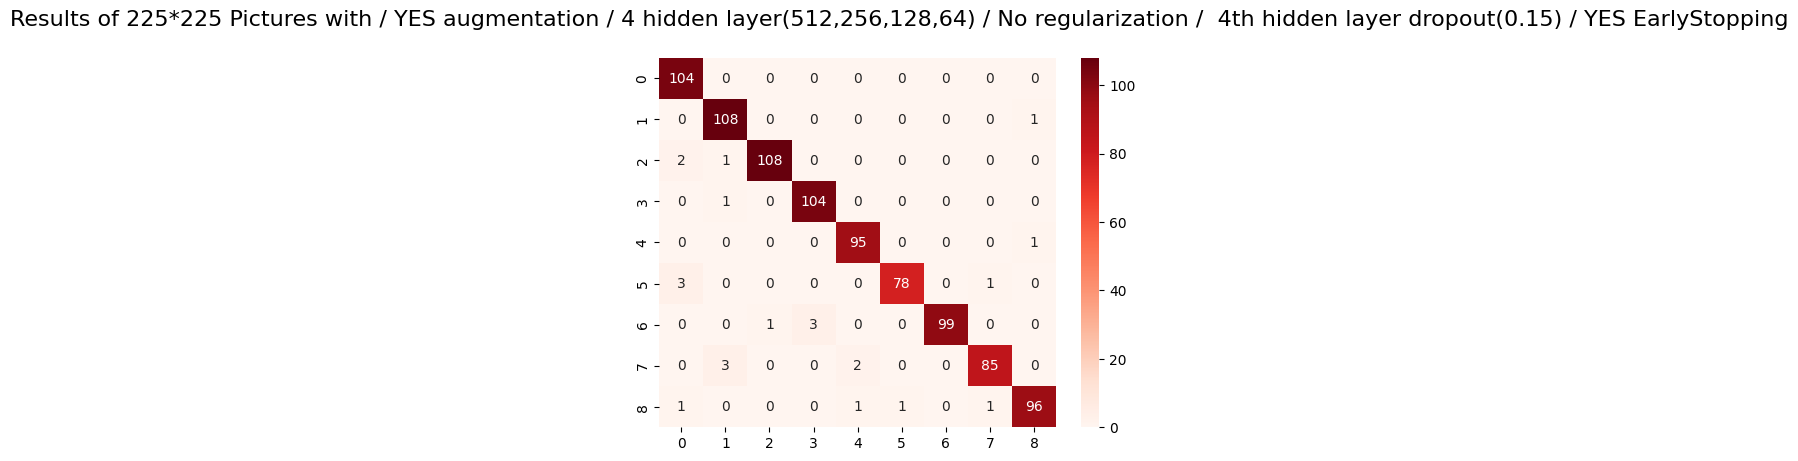

In [24]:
print(classification_report(y_true_labels, y_pred_labels))
sns.heatmap(confusion_matrix(y_true_labels, y_pred_labels), annot=True, fmt='d', cmap='Reds')
plt.suptitle(title, fontsize=16)
plt.show()